# Range to Target calculator

Paul Siqueira
IEEE GRSS Modeling School, Beijing 2025

This jupyter notebook calculates the effect of motion errors for the focusing of targets using Synthetic Aperture Radar

In [33]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [34]:
# target location
target_loc = (10000,0,0)

# aircraft start and end locations
aircraft_start = (0,-100,10000)
aircraft_end = (0,+100,10000)

# number of points for discretization
npoints = 200

# some user-defined quantities
meas_error = 0.01   # motion measurement error, in units of meters

In [35]:
# create an ideal flightline
points = np.linspace(aircraft_start, aircraft_end, num=npoints)
x_pts = points[:, 0]
y_pts = points[:, 1]
z_pts = points[:, 2]

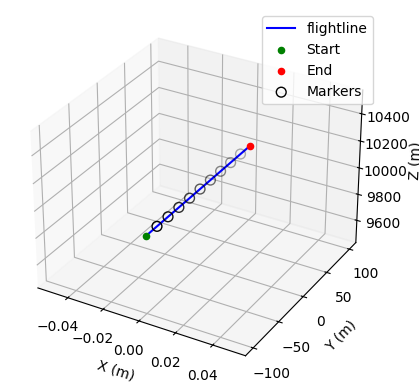

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the line
ax.plot(x_pts, y_pts, z_pts, label='flightline', color='blue')
ax.scatter(*aircraft_start, color='green', label='Start')
ax.scatter(*aircraft_end, color='red', label='End')

# subset the points to show every tenth one, to make the plotting look nicer
nsub_pts = 10
nskip = round(npoints/nsub_pts)
x_pts_sub = points[::nskip, 0]
y_pts_sub = points[::nskip, 1]
z_pts_sub = points[::nskip, 2]

ax.scatter(x_pts_sub[1::], y_pts_sub[1::], z_pts_sub[1::],
           marker='o',
           facecolors='none',
           edgecolors='black',
           s=50,   # size of the circles
           label='Markers')

# Labels and legend
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()

plt.show()

In [37]:
# calculate the distance to the target for each point along the flightline

R = np.linalg.norm(points - target_loc, axis=1)

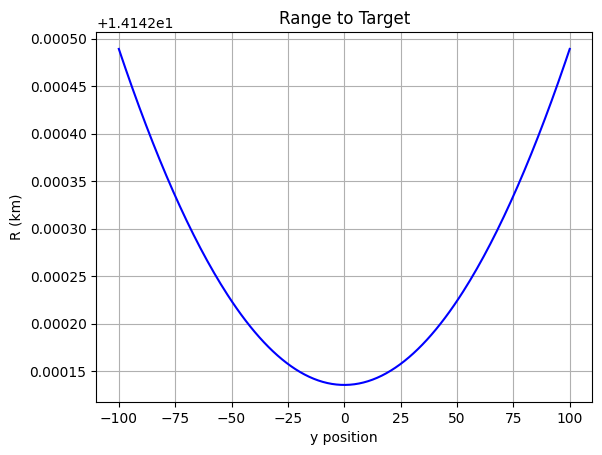

In [38]:
# Plot the Range to Target as it changes along the flightline

plt.plot(y_pts, (R/1000.0), color='blue')
plt.xlabel('y position')
plt.ylabel('R (km)')
plt.title('Range to Target')
plt.grid(True)
plt.show()


In [39]:
# calculate the frequency, the wavelenght, the wavenumber and convert it into a phase

freq = 13.6e9
c = 3e8
lam = c/freq
wavenum = 2*np.pi/lam
phase = 2*wavenum*R

# calculate the effect of phase wrapping (i.e. we can't observe absolute phase)
phase_wrapped = phase % (2*np.pi)

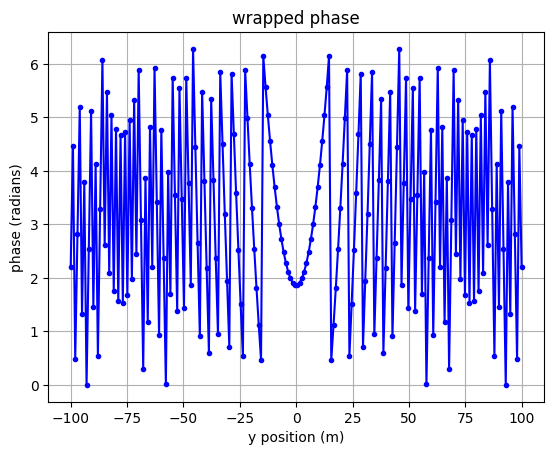

In [40]:
# Plot the wrapped phase

plt.plot(y_pts, phase_wrapped, '.-', color='blue')
plt.xlabel('y position (m)')
plt.ylabel('phase (radians)')
plt.title('wrapped phase')
plt.grid(True)
plt.show()

In [41]:
# add the effect of motion errors to the flightline

gaussian_noise = np.random.normal(loc=0, scale=meas_error, size=npoints)
x_pts_error = x_pts + gaussian_noise
points_error = np.stack((x_pts_error, y_pts, z_pts), axis=1)
R_error = np.linalg.norm(points_error - target_loc, axis=1)
phase_error = 2*wavenum*R_error

# calculate the effect of phase wrapping (i.e. we can't observe absolute phase)
phase_error_wrapped = phase_error % (2*np.pi)

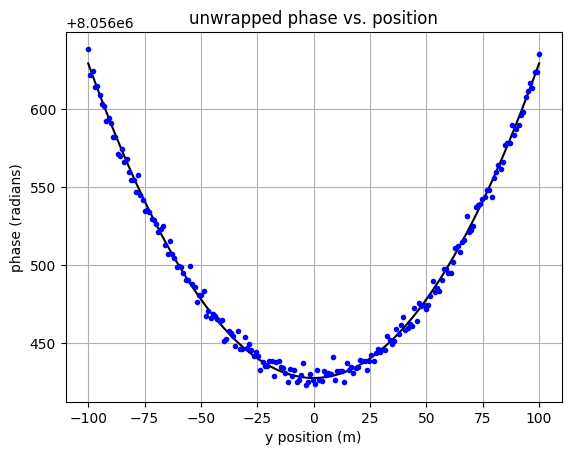

In [42]:
plt.plot(y_pts, phase, '-', color='black')
plt.plot(y_pts, phase_error, '.', color='blue')
plt.xlabel('y position (m)')
plt.ylabel('phase (radians)')
plt.title('unwrapped phase vs. position')
plt.grid(True)
plt.show()

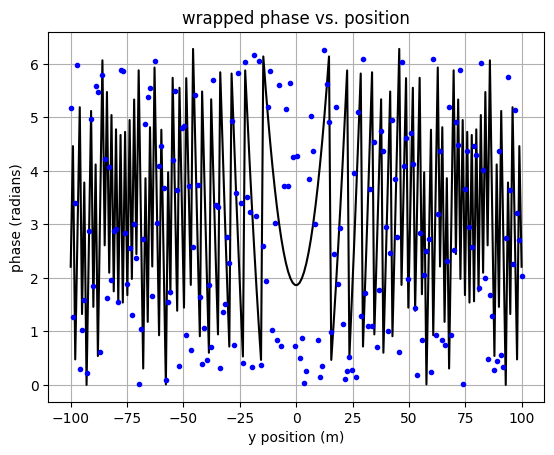

In [43]:
plt.plot(y_pts, phase_wrapped, '-', color='black')
plt.plot(y_pts, phase_error_wrapped, '.', color='blue')
plt.xlabel('y position (m)')
plt.ylabel('phase (radians)')
plt.title('wrapped phase vs. position')
plt.grid(True)
plt.show()

In [44]:
# Convert to an exponential form, and correct the observed return for the estimated target path

ant_gain = 1.0
estimated_signal = ant_gain * np.exp(1.0j * phase)
actual_signal = ant_gain * np.exp(1.0j * phase_error)

perfect_signal = actual_signal
perfect_correction = actual_signal * np.conj(perfect_signal)    # we don't actua
imperfect_correction = actual_signal * np.conj(estimated_signal)
magnitude_perfect = abs(sum(perfect_correction)/len(perfect_correction))
magnitude_imperfect = abs(sum(imperfect_correction)/len(imperfect_correction))
print(f"Radar cross-section for {meas_error: 6.4f} m of motion error, wavelenghth = {lam: 5.3f} m")
print(f"  Perfect Correction: {np.log10(magnitude_perfect):5.2f} dB")
print(f"Imperfect Correction: {np.log10(magnitude_imperfect):5.2f} dB")

Radar cross-section for  0.0100 m of motion error, wavelenghth =  0.022 m
  Perfect Correction:  0.00 dB
Imperfect Correction: -1.27 dB


# Homework problems

1.1  Create a plot that shows the value of the imperfect correction for as the motion measurement error, in units of standard deviation, varies from 0.0 to 2.0 wavelengths, in units of 0.01 wavelengths

1.2  Using a position error of 1/20th of a wavelength, include the effect of an antenna pattern magnitude in the problem.  For this part, assume a 1 meter wide antenna, and a model for the antenna pattern to be a sinc function following the model below.

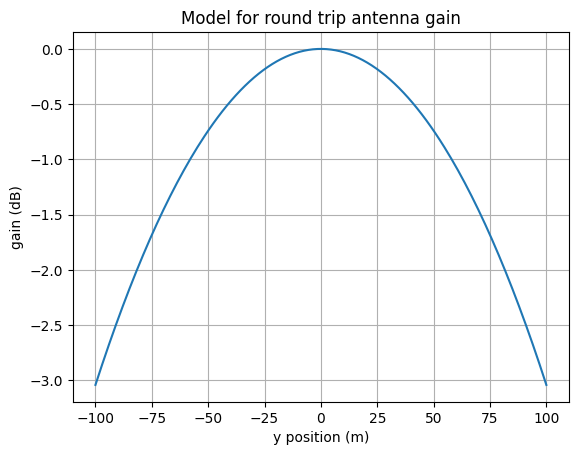

In [45]:
ant_width = 1.0  # in units of meters
ant_angle = np.arctan2(y_pts,R)
ant_gain = np.sinc(ant_width/lam * ant_angle)   # the factor, ant_width/lam is an approximation for the gain pattern 

plt.plot(y_pts,40*np.log10(ant_gain));    # the factor of 40 accounts for both the transmit and receive antenna gains (i.e. 2*20log10())
plt.xlabel('y position (m)')
plt.ylabel('gain (dB)')
plt.title('Model for round trip antenna gain')
plt.grid(True)
plt.show()

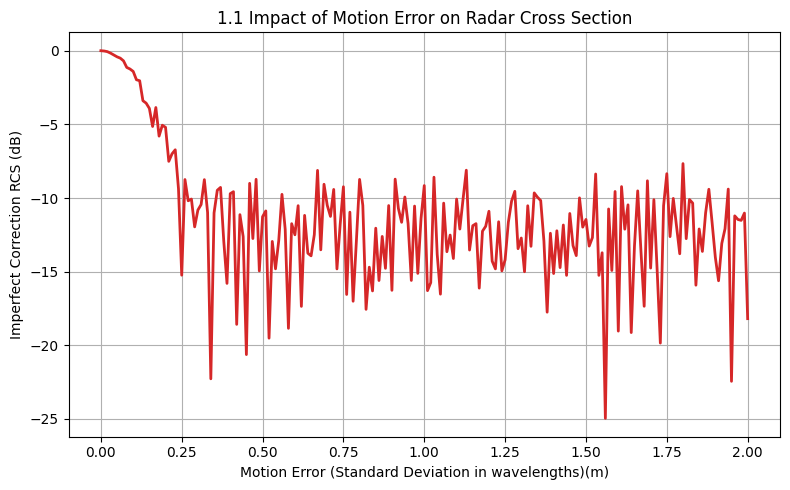

In [46]:
# 1.1
# I'm not sure weather we need static motion error or not, so I will just use the same as in the previous example
# Define the error range in wavelengths
error_wls = np.arange(0.00, 2.01, 0.01)

# 2. placeholder for storing imperfect correction dB values
imperfect_dBs = []

# 3. suppose a constant antenna gain
ant_gain_constant = 1.0
estimated_signal = ant_gain_constant * np.exp(1.0j * phase)

# 4. Cycle for each error level
for err_wl in error_wls:
    # 4.1 convert the error from wavelengths to meters
    meas_error_m = err_wl * lam

    # 4.2 Superimpose Gaussian noise in the x direction
    gn = np.random.normal(loc=0.0, scale=meas_error_m, size=npoints)
    pts_err = np.stack((x_pts + gn, y_pts, z_pts), axis=1)

    # 4.3 Recalculate the distance, phase, and echo with error included
    R_err       = np.linalg.norm(pts_err - target_loc, axis=1)
    phase_err   = 2 * wavenum * R_err
    actual_sig  = ant_gain_constant * np.exp(1.0j * phase_err)

    # 4.4 "imperfect correction"：actual * conj(estimated)
    imp_corr = actual_sig * np.conj(estimated_signal)
    mag_imp  = np.abs(imp_corr.sum() / len(imp_corr))

    # 4.5 Convert to dB storage
    imperfect_dBs.append(10 * np.log10(mag_imp))

# 5. plot error (in wavelengths) vs. imperfect correction (in dB)
plt.figure(figsize=(8,5))
plt.plot(error_wls, imperfect_dBs, lw=2, color='C3')
plt.xlabel('Motion Error (Standard Deviation in wavelengths)(m)')
plt.ylabel('Imperfect Correction RCS (dB)')
plt.title('1.1 Impact of Motion Error on Radar Cross Section')
plt.grid(True)
plt.tight_layout()
plt.show()

1.2: The influence of antenna pattern on radar signal processing
solid position error: 0.001103 m = λ/20
lambda: 0.022059 m

Comparison of RCS values:
Pattern    | Magnitude  | RCS (dB)  
--------------------------------
Constant   | 0.9107     | -0.81     
Sinc       | 0.8153     | -1.77     

Difference due to antenna pattern: -0.96 dB


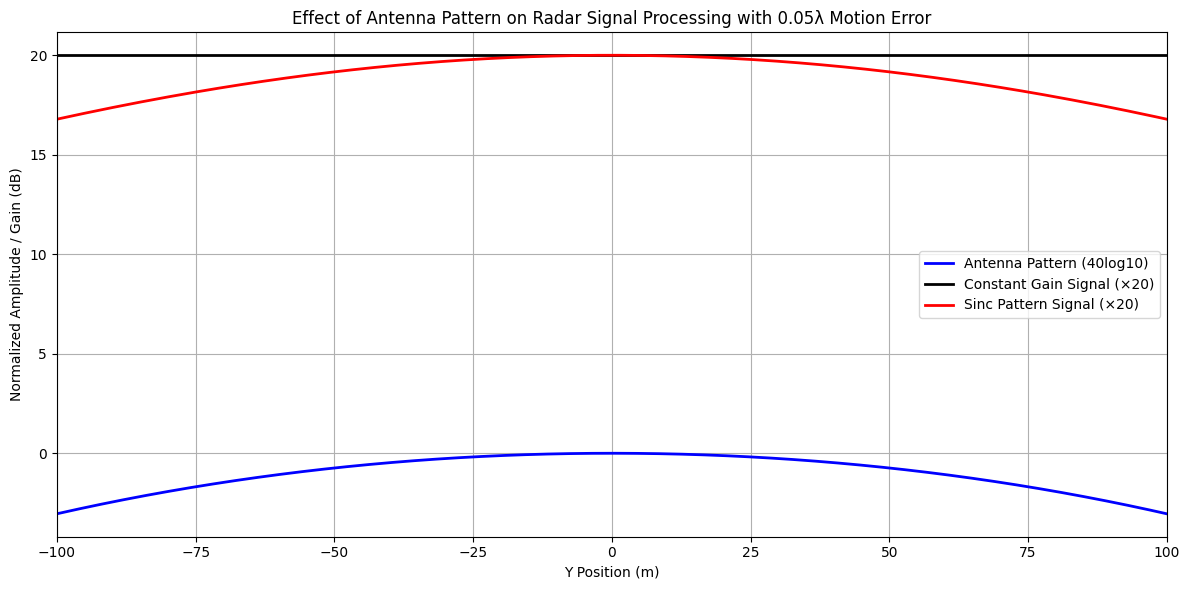

In [47]:
# 1.2 - The influence of antenna pattern on radar signal processing（solid error 0.05λ）
position_error_1_2 = lam / 20.0  # 1/20th of a wavelength in meters

print(f"1.2: The influence of antenna pattern on radar signal processing")
print(f"solid position error: {position_error_1_2:.6f} m = λ/20")
print(f"lambda: {lam:.6f} m")

# flightline with errors
points = np.linspace(aircraft_start, aircraft_end, num=npoints)
x_pts = points[:, 0]
y_pts = points[:, 1]
z_pts = points[:, 2]

gaussian_noise_1_2 = np.random.normal(loc=0, scale=position_error_1_2, size=npoints)
x_pts_error_1_2 = x_pts + gaussian_noise_1_2
points_error_1_2 = np.stack((x_pts_error_1_2, y_pts, z_pts), axis=1)

# Calculate the distance and phase with error
R_error_1_2 = np.linalg.norm(points_error_1_2 - target_loc, axis=1)
phase_error_1_2 = 2*wavenum*R_error_1_2

# pattern A: constant gain
ant_gain_constant = 1.0
estimated_signal_A = ant_gain_constant * np.exp(1.0j * phase)
actual_signal_A = ant_gain_constant * np.exp(1.0j * phase_error_1_2)
imperfect_correction_A = actual_signal_A * np.conj(estimated_signal_A)
magnitude_imperfect_A = abs(sum(imperfect_correction_A)/len(imperfect_correction_A))
rcs_A_db = 10 * np.log10(magnitude_imperfect_A**2)

# pattern B: sinc-like gain pattern
estimated_signal_B = ant_gain * np.exp(1.0j * phase)
actual_signal_B = ant_gain * np.exp(1.0j * phase_error_1_2)
imperfect_correction_B = actual_signal_B * np.conj(estimated_signal_B)
magnitude_imperfect_B = abs(sum(imperfect_correction_B)/len(imperfect_correction_B))
rcs_B_db = 10 * np.log10(magnitude_imperfect_B**2)

# the results
print("\nComparison of RCS values:")
print(f"{'Pattern':<10} | {'Magnitude':<10} | {'RCS (dB)':<10}")
print(f"{'-'*32}")
print(f"{'Constant':<10} | {magnitude_imperfect_A:<10.4f} | {rcs_A_db:<10.2f}")
print(f"{'Sinc':<10} | {magnitude_imperfect_B:<10.4f} | {rcs_B_db:<10.2f}")
print(f"\nDifference due to antenna pattern: {rcs_B_db - rcs_A_db:.2f} dB")

# plot - 合并到一张图
plt.figure(figsize=(12, 6))

# 绘制天线方向图和信号对比
plt.plot(y_pts, 40 * np.log10(ant_gain), 'b-', linewidth=2, label='Antenna Pattern (40log10)')
plt.plot(y_pts, np.abs(actual_signal_A) * 20, 'k-', linewidth=2, label='Constant Gain Signal (×20)')
plt.plot(y_pts, np.abs(actual_signal_B) * 20, 'r-', linewidth=2, label='Sinc Pattern Signal (×20)')

plt.xlabel('Y Position (m)')
plt.ylabel('Normalized Amplitude / Gain (dB)')
plt.title('Effect of Antenna Pattern on Radar Signal Processing with 0.05λ Motion Error')
plt.legend()
plt.grid(True)
plt.xlim(-100, 100)
plt.tight_layout()
plt.show()